In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools
import joblib

In [2]:
#file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025_updated_tr.csv"
df = pd.read_csv(file_path, sep=";")
df = df[df["EGS.VEDTAK.10670"].notna()]
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" or x == "Avslag etter klage "else 0)
if "Kurvatur, horisontalelement" in df.columns:
    df["Kurvatur, horisontal"] = df["Kurvatur, horisontalelement"]
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    "Kurvatur, stigning"
    #"soknadstype",
]



In [3]:
df=df[features]

In [4]:
#df["soknadstype"].value_counts()

In [5]:
#df = df[df["soknadstype"] != "Avslag"]

In [6]:
#df["soknadstype"].value_counts()

In [7]:
# Encode categorical features
df_encoded = pd.get_dummies(df[features])
df_encoded=df_encoded.dropna()
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)

In [8]:
df_encoded=df_encoded.sample(frac=1)

In [9]:
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [10]:
df_encoded

,Avslag_ind,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",...,EGS.BRUKSOMRÅDE.1256_Industri,EGS.BRUKSOMRÅDE.1256_Naust,EGS.BRUKSOMRÅDE.1256_Service,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage,sving_ind,bakke,bakke_ind,sving_sigmoid,antall_lange_kj
42,0,1500.0,13.0,60.0,10,6,False,False,False,True,...,False,False,False,False,False,1,0.3,1,0.606351,195.00
461,0,300.0,9.0,80.0,11,0,True,False,False,False,...,False,False,False,False,False,0,2.7,1,0.000000,27.00
349,0,1510.0,8.0,50.0,13,2,True,False,False,False,...,False,False,False,False,False,1,2.6,1,0.670180,120.80
142,0,612.0,17.0,80.0,12,3,False,False,False,True,...,False,False,False,False,False,1,1.3,1,0.617275,104.04
13,0,1300.0,10.0,80.0,4,3,False,False,False,True,...,False,False,False,True,False,1,2.4,1,0.617275,130.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,0,100.0,9.0,50.0,14,1,False,False,True,False,...,False,False,False,False,False,1,1.4,1,0.601807,9.00
337,0,550.0,15.0,80.0,5,2,False,False,False,True,...,False,False,False,False,False,1,1.4,1,0.883911,82.50
378,0,400.0,9.0,80.0,13,1,True,False,False,False,...,False,False,True,False,False,1,12.5,1,0.536435,36.00
56,0,2500.0,5.0,60.0,6,22,False,False,False,True,...,True,False,False,False,False,1,2.9,1,0.581029,125.00


In [11]:
poly = PolynomialFeatures(3, include_bias=False, interaction_only=True) 
X = pd.DataFrame(poly.fit_transform(X),columns=poly.get_feature_names_out(X.columns))
X.shape

(456, 4089)

In [12]:
model = BalancedRandomForestClassifier(
    sampling_strategy=0.5,
    n_estimators=1000,
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
# Select top 10 features
top_features = importances_sorted.index[:10]
X = X[top_features]
print(top_features)

Index(['ÅDT, total Avkjørsler bakke', 'ÅDT, total Avkjørsler',
       'ÅDT, total antall_lange_kj',
       'ÅDT, andel lange kjøretøy Avkjørsler antall_lange_kj',
       'Avkjørsler bakke antall_lange_kj',
       'ÅDT, total Avkjørsler antall_lange_kj', 'Avkjørsler antall_lange_kj',
       'ÅDT, total bakke', 'ÅDT, total ÅDT, andel lange kjøretøy',
       'ÅDT, total Fartsgrense Avkjørsler'],
      dtype='object')


In [13]:
#Index(['ÅDT, total Avkjørsel, holdningsklasse_Streng EGS.BRUKSOMRÅDE.1256_Bolig bakke',
#       'ÅDT, total bakke', 'ÅDT, total bakke bakke_ind',
#       'ÅDT, andel lange kjøretøy Fartsgrense Avkjørsel, holdningsklasse_Streng EGS.BRUKSOMRÅDE.1256_Bolig bakke',
#       'Avkjørsel, holdningsklasse_Streng EGS.BRUKSOMRÅDE.1256_Bolig bakke bakke_ind antall_lange_kj'],
#      dtype='object')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=43)

In [15]:
smote = ADASYN(sampling_strategy=0.5, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [16]:
y_train.sum()/y_train.count()

0.32642487046632124

In [17]:
model = BalancedRandomForestClassifier(n_estimators=5000,
                              random_state=42, n_jobs=-1, sampling_strategy=1)
model.fit(X_train, y_train)

,n_estimators,5000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [18]:
y_pred=model.predict(X_test)
y_proba=model.predict_proba(X_test)[:,1]

In [19]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9728    0.8034    0.8800       178
           1     0.0278    0.2000    0.0488         5

    accuracy                         0.7869       183
   macro avg     0.5003    0.5017    0.4644       183
weighted avg     0.9470    0.7869    0.8573       183



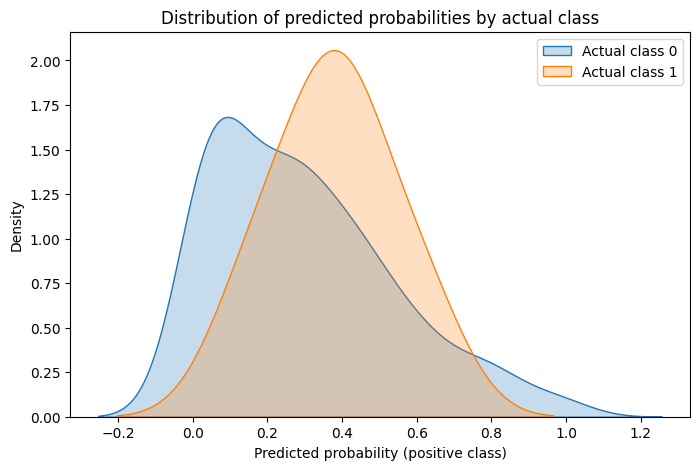

In [20]:
# Combine into one DataFrame for easy plotting
import pandas as pd
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [21]:
import pickle
# Save it
with open("balanced_rf_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [22]:
joblib.dump(model, "balanced_rf_model.joblib")

['balanced_rf_model.joblib']

In [23]:
y_proba

array([0.607     , 0.014     , 0.61      , 0.33866667, 0.25046667,
       0.036     , 0.3024    , 0.007     , 0.0196    , 0.2936    ,
       0.0758    , 0.31241667, 0.1736    , 0.603     , 0.0062    ,
       0.0076    , 0.1482    , 0.4624    , 0.4456    , 0.0112    ,
       0.0544    , 0.0668    , 0.79006667, 0.5096    , 0.54513333,
       0.4426    , 0.0834    , 0.7446    , 0.0184    , 0.0078    ,
       0.5276    , 0.0076    , 0.2134    , 0.40076667, 0.5596    ,
       0.36223333, 0.4648    , 0.1428    , 0.3508    , 0.4409    ,
       0.61513333, 0.631     , 0.1878    , 0.055     , 0.15829   ,
       0.7658    , 0.3446    , 0.415     , 0.2678    , 0.6372    ,
       0.359     , 0.125     , 0.26265   , 0.5328    , 0.46121667,
       0.808     , 0.29906667, 0.0198    , 0.1382    , 0.3044    ,
       0.4318    , 0.015     , 0.2266    , 0.375     , 0.2418    ,
       0.2398    , 0.1667    , 0.1358    , 0.1068    , 0.3804    ,
       0.1794    , 0.288     , 0.42      , 0.28      , 0.667  

In [24]:
y_proba.mean()

0.30000418943533697

In [26]:
import gzip

In [27]:
with open("balanced_rf_model.pkl", "rb") as f_in:
    with gzip.open("balanced_rf_model.pkl.gz", "wb") as f_out:
        f_out.write(f_in.read())